In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os

import matplotlib.pyplot as plt
from dgl.data import BACommunityDataset
import networkx as nx
import torch_geometric
import dgl
from copy import deepcopy, copy


In [4]:
from src.model import *
from src.data import *
from src.explainer import *
from src.plot import *
from src.modify import *
from src.protgnn import *
from src.util import *

In [5]:
ba_dataset = get_dataset("BAShapes")

Done loading data from cached files.


/rds/user/njr61/hpc-work/anaconda3/envs/gnn/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
num_classes = len(set([int(i) for i in ba_dataset.y]))
num_features = ba_dataset.x.shape[-1]

In [7]:
epochs = 3000
dim = 20

## Model Setup

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
model = NetSmall(num_features=num_features, dim=dim, num_classes=num_classes).to(device)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

In [11]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model)

[Train_loss:1.326827 Train_acc: 0.2679, Test_acc: 0.0714]: 100%|█| 3000/300


In [12]:
model.eval()

NetSmall(
  (conv1): GCNConv(1, 20)
  (conv2): GCNConv(20, 20)
  (linear): Linear(in_features=20, out_features=4, bias=False)
)

In [13]:
gce_explainer = GCExplainer(layer_name="conv2")

In [14]:
gce_explainer.learn_prototypes(model,ba_dataset)

/rds/user/njr61/hpc-work/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
gce_explainer.get_prediction(model,ba_dataset)

array([0, 2, 2, 3, 2, 2, 3, 0, 2, 2, 3, 2, 3, 2, 2, 3, 2, 0, 3, 1, 2, 2,
       3, 2, 2, 1, 1, 2, 0, 3, 3, 3, 2, 1, 0, 2, 3, 2, 2, 0, 0, 3, 2, 2,
       1, 2, 2, 3, 3, 0, 1, 1, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 2, 2, 3, 3,
       3, 0, 0, 2, 3, 1, 0, 0, 0, 0, 3, 3, 3, 2, 2, 3, 0, 2, 2, 1, 3, 3,
       3, 3, 2, 1, 3, 0, 3, 3, 1, 0, 0, 3, 2, 1, 3, 2, 2, 3, 1, 1, 2, 1,
       3, 0, 0, 2, 2, 0, 2, 3, 0, 2, 3, 2, 0, 2, 3, 2, 2, 1, 1, 3, 2, 2,
       1, 2, 3, 1, 1, 0, 0, 1])

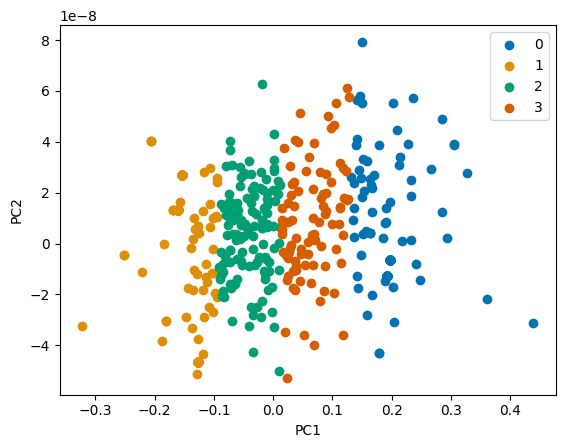

In [16]:
plot_kmeans_clusters(gce_explainer.kmeans,gce_explainer.initial_activations)

## Low-Level Matrices

In [17]:
num_nodes = ba_dataset.num_nodes
num_features = ba_dataset.num_features
edge_index = ba_dataset.edge_index
targeted_node = 5
num_gcn_layers = sum(1 for module in model.modules() if isinstance(module, GCNConv))

In [18]:
all_activations, points_by_cluster = gce_explainer.get_prediction(model,ba_dataset,test=False, get_activations=True)
centers = gce_explainer.kmeans.cluster_centers_
current_vector = all_activations[targeted_node]

In [19]:
A = np.zeros((num_nodes,num_nodes))
for a,b in ba_dataset.edge_index.T:
    A[a,b] = A[b,a] = 1
A_identity = np.eye(num_nodes)
A_squiggle = A + A_identity
X = ba_dataset.x.detach().numpy()
W = compute_W(model)

In [20]:
A_hat = compute_A_hat(A_squiggle)
AXW = compute_AXW(A_hat,X,W,num_gcn_layers)

## Run the Targeted Attack

In [51]:
current_location = AXW[targeted_node]
get_kmeans_distances(centers,current_location)

array([0.30108966, 0.0394369 , 0.06643955, 0.17102286])

In [69]:
new_location = current_location + get_movement_direction_minmax(centers,current_location)
get_kmeans_distances(centers,new_location)

array([0.23465011, 0.10587645, 0.        , 0.10458331])

In [107]:
def new_score_function(current_location,centers,current_prediction):
    distances = get_kmeans_distances(centers,current_location)
    return -np.min(np.delete(distances,current_prediction))

In [113]:
changes_minmax = targeted_attack(ba_dataset,gce_explainer,model,targeted_node,10,
                   new_score_function, get_movement_direction_coloumb)
changes_minmax

Distances [0.30108966 0.0394369  0.06643955 0.17102286]
Max score (-0.028481346980527355, 'A', 77, 5, 0.0)
Distances [0.26313146 0.0773951  0.02848135 0.13306466]


[('A', 77, 5, 0.0)]

In [109]:
A_squiggle_new, X_new = modify_A_X(changes_minmax,A_squiggle,X)
A_hat_new = compute_A_hat(A_squiggle_new)
AXW_new = compute_AXW(A_hat_new,X_new,W,num_gcn_layers)

In [104]:
current_location = AXW_new[targeted_node]
get_kmeans_distances(centers,current_location)

array([1.71507713, 1.37455058, 1.48042702, 1.58501034])